### 0. Prepare Envr

In [1]:
import os, warnings
import matplotlib.pyplot as plt 
from matplotlib import gridspec

import numpy as np
import tensorflow as tf 

plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight = 'bold', labelsize = 'large',
      titleweight = 'bold', titlesize = 18, titlepad = 10)
plt.rc('image', cmap = 'magma')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import numpy as np
from itertools import product

def show_kernel(kernel, label = True, digits = None, 
               text_size = 28):
    # format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)
    
    # plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap = cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max() + kernel.min())/2
    
    # add value labels, optional
    if label:
        for i,j in product(range(rows), range(cols)):
            val = kernel[i,j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val,
                    color = color, size = text_size,
                    horizontalalignment = 'center',
                    verticalalignment = 'center')
            plt.xticks([])
            plt.yticks([])

### 1. Convolutional NN

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

#### <font color = '#5b5b5b'>Load Image from Directory</font>

In [5]:
def set_seed(seed = 31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)




ds_train_ = image_dataset_from_directory(
            'Documents/archive/train',
            labels='inferred',
            label_mode='binary',
            image_size=[224, 224],
            interpolation='nearest',
            batch_size=64,
            shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
            'Documents/archive/valid',
            labels= 'inferred',
            label_mode='binary',
            image_size=[224,224],
            interpolation='nearest',
            batch_size=64,
            shuffle=False,)

def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype = tf.float32)
    return image, label


AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = (ds_train_
            .map(convert_to_float)
            .cache()
            .prefetch(buffer_size = AUTOTUNE))
ds_valid = (ds_valid_
            .map(convert_to_float)
            .cache()
            .prefetch(buffer_size = AUTOTUNE))

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


#### <font color = '#5b5b5b'>import model from tfhub</font>

In [ ]:
import tensorflow_hub as hub
pretrained_base = hub.KerasLayer('https://tfhub.dev/google/imagenet/inception_v1/classification/5')

In [7]:
pretrained_base.trainable = False

NameError: name 'pretrained_base' is not defined

In [7]:
model = keras.Sequential([
        pretrained_base,
        layers.Flatten(),
        layers.Dense(6, activation = 'relu'),
        layers.Dense(1, activation = 'sigmoid'),
])

#### <font color = '#5b5b5b'>_Beginning of Data Augmentation_</font>

In [6]:
from tensorflow.keras.layers.experimental import preprocessing

pretrained_base = tf.keras.models.load_model('Documents/vgg16-pretrained-base',)
pretrained_base.trainable = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

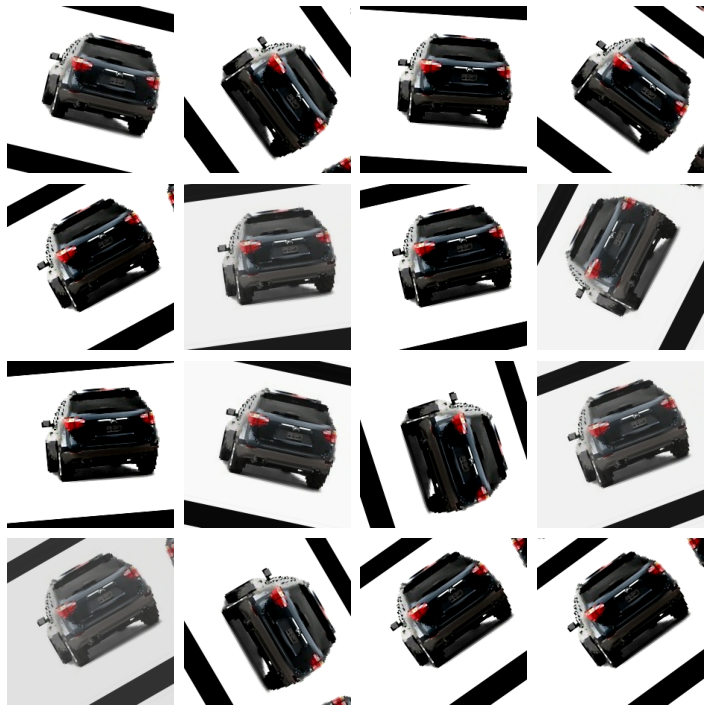

In [7]:
# explore augmentation args
augment = keras.Sequential([
        preprocessing.RandomContrast(factor = .50),
#         preprocessing.RandomFlip(mode = 'horizontal'),
#         preprocessing.RandomFlip(mode = 'vertical'),
#         preprocessing.RandomWidth(factor = .15),
#         preprocessing.RandomRotation(factor = .20),
#         preprocessing.RandomTranslation(height_factor = .10, width_factor = .01),

])

ex = next(iter(ds_train.unbatch().map(lambda x,y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training = True)
    plt.subplot(4,4,i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

In [7]:
# set up model to include variance
model = keras.Sequential([
    preprocessing.RandomFlip('horizontal'), # flip l-2-r
    preprocessing.RandomContrast(.5), # contrast change by up to 50%
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid'),
])

#### <font color = '#5b5b5b'>_End of Data Augmentation_</font>

In [10]:
model.compile(optimizer= tf.keras.optimizers.Adam(epsilon=.05),
             loss = 'binary_crossentropy',
             metrics=['binary_accuracy'],
             )

history = model.fit(ds_train,
                   validation_data=ds_valid,
                   epochs=30,
                   )

Epoch 1/30
80/80 [==============================] - ETA: 0s - loss: 0.5575 - binary_accuracy: 0.8040

KeyboardInterrupt: 

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:,['loss','val_loss']].plot()
history_frame.loc[:['binary_accuracy','val_binary_accuracy']].plot()

### 2. Convolution and ReLu

#### <font color = '#5b5b5b'>Load Image</font>

In [9]:
image_path = 'Documents/archive/car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

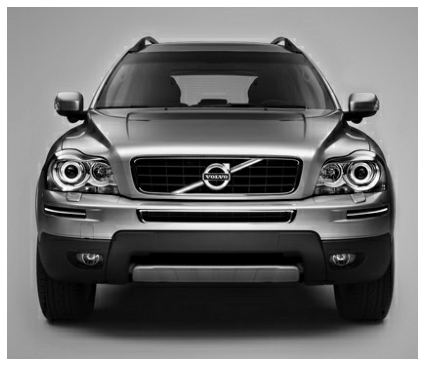

In [10]:
plt.figure(figsize=(6,6))
plt.imshow(tf.squeeze(image),cmap = 'gray')
plt.axis('off')
plt.show()

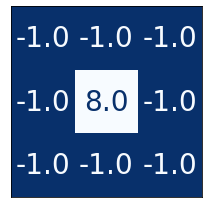

In [11]:
kernel = tf.constant([
        [-1,-1,-1],
        [-1,8,-1],
        [-1,-1,-1]
], dtype = tf.float32)
plt.figure(figsize=(3,3))
show_kernel(kernel)

In [12]:
# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis = 0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])

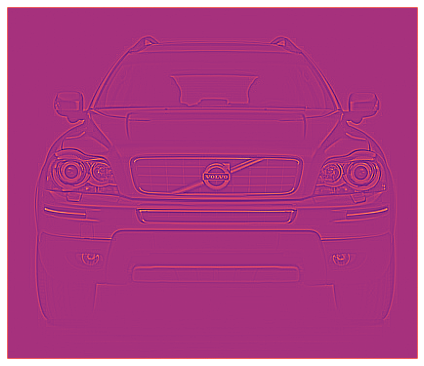

In [13]:
image_filter = tf.nn.conv2d(input = image,
                           filters=kernel,
                           strides=1,
                           padding='SAME',
                           )

plt.figure(figsize = (6,6))
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.show()

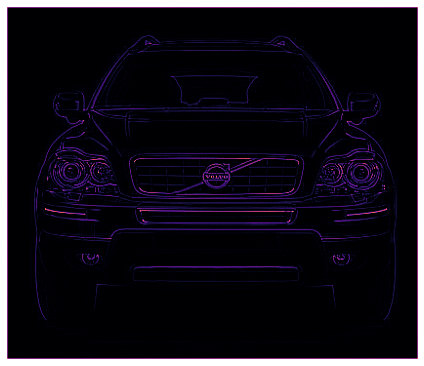

In [17]:
image_detect = tf.nn.relu(image_filter)

plt.figure(figsize = (6,6))
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.show()

### 3. Maximum Pooling

#### 3-1. Maxmium Pooling

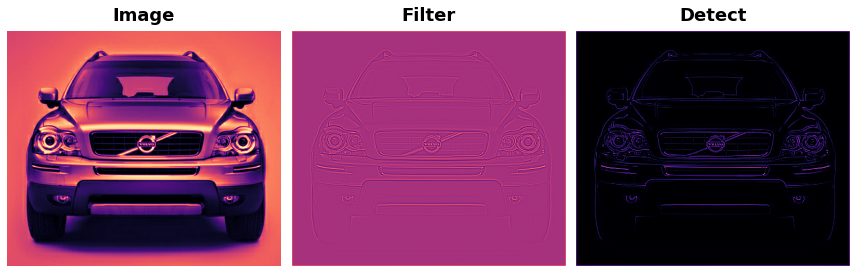

In [18]:
# follows 2

# show all figs in one grid
plt.figure(figsize = (12,6))
pics = [image, image_filter, image_detect]
plots = [131,132,133]
titles = ['Image','Filter','Detect']

for i, j, k in zip(pics, plots, titles):
    plt.subplot(j)
    plt.imshow(tf.squeeze(i))
    plt.axis('off')
    plt.title(k)
plt.show()

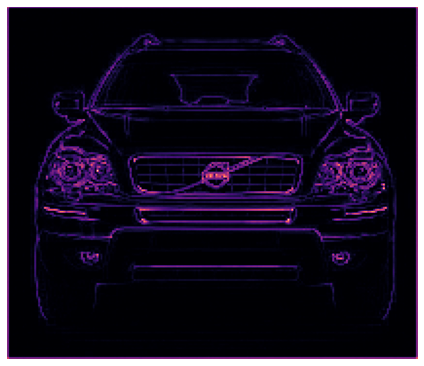

In [23]:
image_condense = tf.nn.pool(
    input=image_detect, # image in the Detect step above
    window_shape=(2, 2),
    pooling_type='MAX',
    # we'll see what these do in the next lesson!
    strides=(2, 2),
    padding='SAME',
)

plt.figure(figsize = (6,6))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.show()

#### 3-2 Global Average Pooling

In [19]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [20]:
from keras.applications.vgg16 import VGG16
pretrained_model = VGG16(include_top=False)

In [22]:
pretrained_model.trainable = False
model = keras.Sequential([
        layers.GlobalAveragePooling2D()
]) 
# use GAP instead of flatten to replace 
#high-level features with an average value/score, 
#then classifying image accordinging to such score 

In [21]:
ds = image_dataset_from_directory('Documents/archive/train',
                                 labels = 'inferred',
                                 label_mode='binary',
                                 image_size=[128,128],
                                 interpolation='nearest',
                                 batch_size=1,
                                 shuffle = True)
ds_iter = iter(ds)

Found 5117 files belonging to 2 classes.


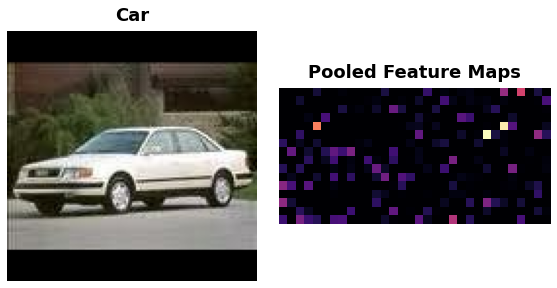

In [39]:
car = next(ds_iter)

car_tf = tf.image.resize(car[0],size=[128,128])
car_features = pretrained_model(car_tf)
car_features = model(car_features) # some dimensional issue when composing pretrained and GlobalAvgPooling together
car_features = tf.reshape(car_features, shape = (16,32))
label = int(tf.squeeze(car[1]).numpy()) # label stored here

plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(tf.squeeze(car[0]))
plt.axis('off')
plt.title(['Car','Truck'][label])
plt.subplot(122)
plt.imshow(car_features)
plt.title('Pooled Feature Maps')
plt.axis('off')
plt.show()

### 4. The Sliding Window

In [42]:
from skimage import draw, transform

In [43]:
def circle(size, val = None, r_shrink = 0):
    circle = np.zeros([size[0]+1, size[1]+1])
    rr, cc = draw.circle_perimeter(
        size[0]//2, size[1]//2,
        radius = size[0]//2 - r_shrink,
        shape = [size[0] + 1, size[1] + 1],
    )
    if val is None:
        circle[rr,cc] = np.random.uniform(size = 
                                         circle.shape)[rr,cc]
    else:
        circle[rr,cc] = val
    circle = transform.resize(circle, size, order = 0)
    return circle

In [44]:
def show_extraction(image,
                    kernel,
                    conv_stride=1,
                    conv_padding='valid',
                    activation='relu',
                    pool_size=2,
                    pool_stride=2,
                    pool_padding='same',
                    figsize=(10, 10),
                    subplot_shape=(2, 2),
                    ops=['Input', 'Filter', 'Detect', 'Condense'],
                    gamma=1.0):
    # Create Layers
    model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(
                        filters=1,
                        kernel_size=kernel.shape,
                        strides=conv_stride,
                        padding=conv_padding,
                        use_bias=False,
                        input_shape=image.shape,
                    ),
                    tf.keras.layers.Activation(activation),
                    tf.keras.layers.MaxPool2D(
                        pool_size=pool_size,
                        strides=pool_stride,
                        padding=pool_padding,
                    ),
                   ])

    layer_filter, layer_detect, layer_condense = model.layers
    kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
    layer_filter.set_weights([kernel])

    # Format for TF
    image = tf.expand_dims(image, axis=0)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) 
    
    # Extract Feature
    image_filter = layer_filter(image)
    image_detect = layer_detect(image_filter)
    image_condense = layer_condense(image_detect)
    
    images = {}
    if 'Input' in ops:
        images.update({'Input': (image, 1.0)})
    if 'Filter' in ops:
        images.update({'Filter': (image_filter, 1.0)})
    if 'Detect' in ops:
        images.update({'Detect': (image_detect, gamma)})
    if 'Condense' in ops:
        images.update({'Condense': (image_condense, gamma)})
    
    # Plot
    plt.figure(figsize=figsize)
    for i, title in enumerate(ops):
        image, gamma = images[title]
        plt.subplot(*subplot_shape, i+1)
        plt.imshow(tf.image.adjust_gamma(tf.squeeze(image), gamma))
        plt.axis('off')
        plt.title(title)

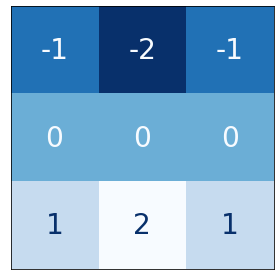

In [45]:
image = circle([64,64],val = 1.0, r_shrink=3)
image = tf.reshape(image, [*image.shape, 1])
kernel = tf.constant([
        [-1,-2,-1],
        [0, 0 ,0],
        [1, 2, 1],
])
show_kernel(kernel)

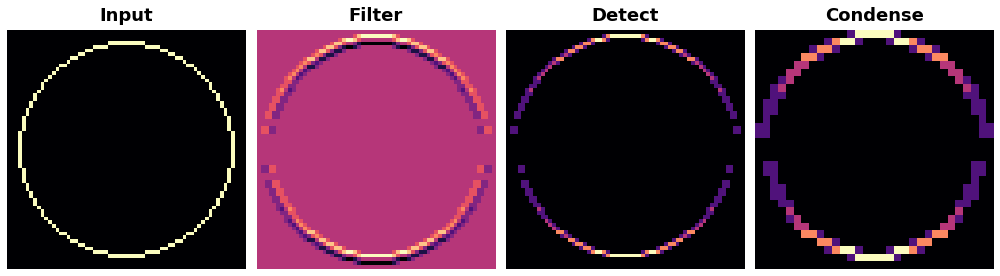

In [46]:
show_extraction(
        image, kernel,
        conv_stride = 1,
        pool_size=2,
        pool_stride=2,

        subplot_shape = (1,4),
        figsize = (14,6),
)

### 5. Custom Convnets

In [48]:
# chain of convolutional blocks to refine extractions
model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(filters = 32, kernel_size = 5,
                     activation = 'relu', padding = 'same',
                     input_shape = [224,224,3]),
        layers.MaxPool2D(),
        
        # 2nd Convolutional Block
        layers.Conv2D(filters = 64, kernel_size = 3,
                     activation = 'relu', padding = 'same'),
        layers.MaxPool2D(),

        # 3rd Conv Block
        layers.Conv2D(filters = 128, kernel_size = 3,
                     activation = 'relu', padding = 'same'),
        layers.MaxPool2D(),
        
        # Head
        layers.Flatten(),
        layers.Dense(units = 6, activation = 'relu'),
        layers.Dense(units = 1, activation = 'sigmoid'),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)           

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=.01),
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy'])

history = model.fit(
        ds_train, 
        validation_data= ds_valid,
        epochs=30,
)

Epoch 1/30
62/80 [======================>.......] - ETA: 1:43 - loss: 0.6770 - binary_accuracy: 0.5874

KeyboardInterrupt: 

In [ ]:
import pandas as pd
histroy_frame = pd.DataFrame(histroy.histroy)
histroy_frame.loc[:,['loss','val_loss']].plot()
histroy_frame.loc[:,['binary_accuracy','val_binary_accuracy']].plot()

### Append

#### some kernels

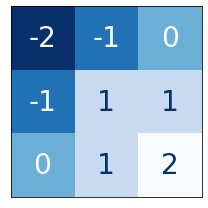

In [28]:
bottom_sobel = tf.constant([
            [-1,-2,-1],
            [0, 0, 0],
            [1, 2, 1]
    ]) # emphasize horizontal/ vertical edges

emboss = tf.constant([
            [-2,-1,0],
            [-1, 1,1],
            [0, 1, 2]
]) # highlight pixels with high contrast

sharpen = tf.constant([
            [0, -1, 0],
            [-1, 5, -1],
            [0, -1, 0]
])

blur = tf.constant([
            [.06, .12, .06],
            [.12, .25, .12],
            [.06, .12, .06]
])

plt.figure(figsize = (3,3))
show_kernel(emboss)

#### Matrix

In [49]:
import sympy
sympy.init_printing()
from IPython.display import display

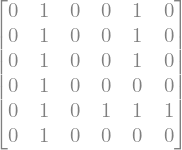

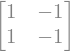

In [50]:
image = np.array([
    [0, 1, 0, 0, 1, 0],
    [0, 1, 0, 0, 1, 0],
    [0, 1, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 1],
    [0, 1, 0, 0, 0, 0]
])

kernel = np.array([
        [1, -1],
        [1, -1]
])

display(sympy.Matrix(image))
display(sympy.Matrix(kernel))

In [6]:
image = tf.cast(image, dtype = tf.float32)
image = tf.reshape(image, [1, *image.shape, 1])

In [7]:
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype = tf.float32)

In [8]:
image_filter = tf.nn.conv2d(
        input = image,
        filters= kernel,
        strides = 1,
        padding = 'VALID')

image_detect = tf.nn.relu(image_filter)

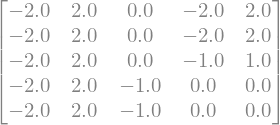

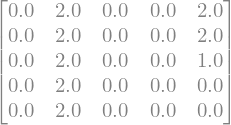

In [9]:
display(sympy.Matrix(tf.squeeze(image_filter).numpy()))
display(sympy.Matrix(tf.squeeze(image_detect).numpy()))

#### One-Dimensional Convolution

In [51]:
# time-series analysis
import pandas as pd 

machinelearning = pd.read_csv('Documents/archive/machinelearning.csv',
                             parse_dates=['Week'],
                             index_col = 'Week',
                             )
machinelearning.plot()

ImportError: this version of pandas is incompatible with numpy < 1.17.3
your numpy version is 1.16.6.
Please upgrade numpy to >= 1.17.3 to use this pandas version

In [ ]:
! pip install --upgrade numpy

In [9]:
# filters for changes in the series
detrend = tf.constant([-1, 1], dtype = tf.float32)
# smooth series, filtering out low-frequency components
average = tf.constant([0.2, 0.2, 0.2, 0.2, 0.2, 0.2], 
                     dtype = tf.float32)
spencer = tf.constant([-3,-6,-5,3,21,46,67,74,67,32,3,-5,-6,-3],
                     dtype= tf.float32)/320

<AxesSubplot:>

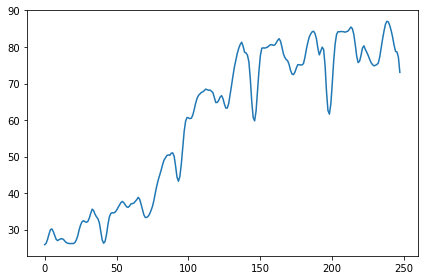

In [16]:
kernel = spencer

ts_data = machinelearning.to_numpy()
ts_data = tf.expand_dims(ts_data, axis = 0)
ts_data = tf.cast(ts_data, dtype = tf.float32)
kern = tf.reshape(kernel, shape = (*kernel.shape, 1, 1))

ts_filter = tf.nn.conv1d(
            input = ts_data,
            filters = kern,
            stride = 1,
            padding = 'VALID',
)

machinelearning_filtered = pd.Series(tf.squeeze(ts_filter).numpy())

machinelearning_filtered.plot()

#### Unfreeze Layers of feature extractor: Subclass API

In [44]:
base_model = keras.applications.VGG16(include_top=False,) # input_shape = ()
base_model.trainable = True

In [47]:
class unfreezed_base_model(keras.Model):
    def __init__(self, base_model):
        super(unfreezed_base_model, self).__init__()
        self.base = base_model
        # head ensues
        self.layer_1 = layers.Flatten()
        self.layer_2 = layers.Dense(64, activation = 'relu'),
        self.layer_3 = layers.Dense(5, activation = 'softmax')
        
        @tf.function
        def call(self, xb):
            x = self.base(xb)
            x = self.layer_1(x)
            x = self.layer_2(x)
            x = self.layer_3(x)
            return x      

In [48]:
model = unfreezed_base_model(base_model = base_model)

#### Other Data Augmentation Techs: color 

In [95]:
def color(x:tf.Tensor) -> tf.Tensor:
    """Color Augmentation
    
    Args:
        x: Image
    
    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, .08)
    x = tf.image.random_saturation(x, .6, 1.6)
    x = tf.image.random_brightness(x, .05)
    x = tf.image.random_contrast(x, .7, 1.3)
    return x 

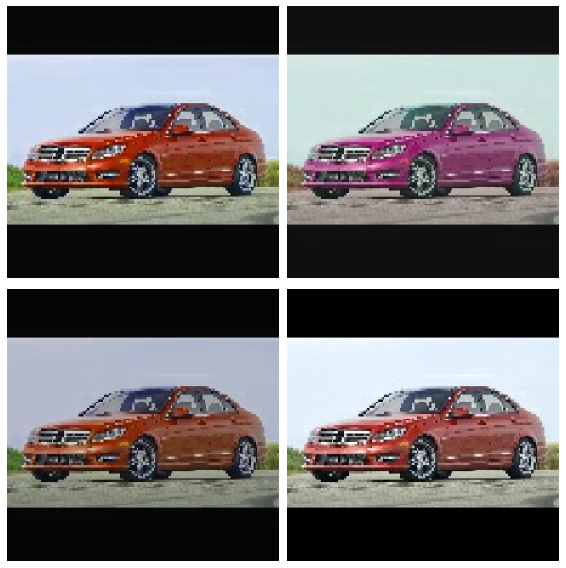

In [96]:
ex = next(iter(ds_train.unbatch().map(lambda x,y: x).batch(1)))

plt.figure(figsize = (8,8))
for i in range(4):
    image = color(ex)
    plt.subplot(2,2,i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()